In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

2025-07-08 14:54:42.449360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 14:54:42.775617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752000882.902236  337762 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752000882.939991  337762 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752000883.216450  337762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import h5py as h5

In [3]:
# f = h5.File('/home/jacob/050625_cascade_default_bert.h5')
f = h5.File('/home/jacob/g4rw_dev/Geant4Reweight/geant4reweight/app/PredictionBase/050625_cascade_default_bert_500k.h5')
# f1_1 = h5.File('/home/jacob/050625_cascade_default_bert_1.h5')
# f1_2 = h5.File('/home/jacob/050625_cascade_default_bert_2.h5')

In [4]:
# pdgs = f['X'][:,:,3].astype(int)

In [5]:
# (pdgs[np.where(f['X'][:,:,3] > 1e9)] - 1.e9)*-1.e-5

In [6]:
# plt.hist((pdgs[pdgs > 1000000000] - 1e9) * -1./1.e5)

In [7]:
# pdgs = f['X'][:]
# pdgs_1 = f1_1['X'][:]
# pdgs_2 = f1_2['X'][:]

In [8]:
testpdg = 2112
# plt.hist(np.sum(pdgs[:, :, 3].astype(int) == testpdg, axis=1), np.arange(0, 10, ), histtype='step')
# plt.hist(np.sum(pdgs_1[:, :, 3].astype(int) == testpdg, axis=1), np.arange(0, 10, ), histtype='step')
# plt.hist(np.sum(pdgs_2[:, :, 3].astype(int) == testpdg, axis=1), np.arange(0, 10, ), histtype='step')

In [9]:
f2 = h5.File('/home/jacob/050625_cascade_shadowing0.1_bert.h5')

In [10]:
f3 = h5.File('/home/jacob/050625_cascade_shadowing0.15_bert.h5')
f4 = h5.File('/home/jacob/050625_cascade_shadowing0.20_bert.h5')
f5 = h5.File('/home/jacob/050625_cascade_shadowing0.25_bert.h5')

In [11]:
f6 = h5.File('/home/jacob/g4rw_dev/Geant4Reweight/geant4reweight/app/PredictionBase/050625_cascade_shadowing1.5_bert_500k.h5')

In [12]:
pdgs2 = f2['X'][:]

In [13]:
pdgs3 = f3['X'][:]
pdgs4 = f4['X'][:]
pdgs5 = f5['X'][:]
pdgs6 = f6['X'][:]

(array([3.10730e+04, 1.28204e+05, 1.06500e+05, 1.82198e+05, 3.91020e+04,
        1.27100e+04, 2.07000e+02, 6.00000e+00, 0.00000e+00]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 [<matplotlib.patches.Polygon at 0x757aa20dc230>])

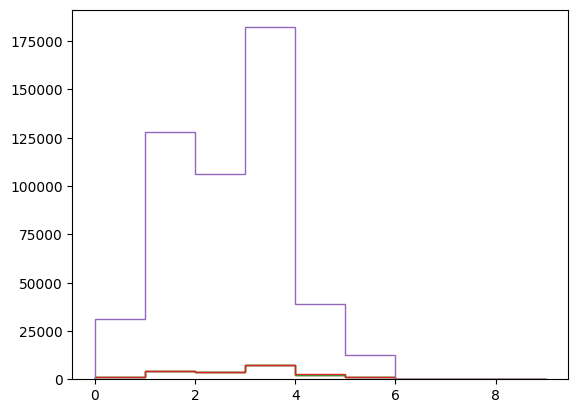

In [14]:
plt.hist(np.sum(pdgs2[:, :, 3].astype(int) == testpdg, axis=1), np.arange(0, 10, 1), histtype='step')
plt.hist(np.sum(pdgs3[:, :, 3].astype(int) == testpdg, axis=1), np.arange(0, 10, 1), histtype='step')
plt.hist(np.sum(pdgs4[:, :, 3].astype(int) == testpdg, axis=1), np.arange(0, 10, 1), histtype='step')
plt.hist(np.sum(pdgs5[:, :, 3].astype(int) == testpdg, axis=1), np.arange(0, 10, 1), histtype='step')
plt.hist(np.sum(pdgs6[:, :, 3].astype(int) == testpdg, axis=1), np.arange(0, 10, 1), histtype='step')

In [15]:
PID2FLOAT_MAP = {22: 0,
                 211: .1, -211: .2, 
                 321: .3, -321: .4, 
                 130: .5, 
                 2112: .6, -2112: .7, 
                 2212: .8, -2212: .9, 
                 11: 1.0, -11: 1.1,
                 13: 1.2, -13: 1.3,
}

def remap_pids2(events, pid_i=3, error_on_unknown=True):
    """Remaps PDG id numbers to small floats for use in a neural network.
    `events` are modified in place and nothing is returned.

    **Arguments**

    - **events** : _numpy.ndarray_
        - The events as an array of arrays of particles.
    - **pid_i** : _int_
        - The column index corresponding to pid information in an event.
    - **error_on_unknown** : _bool_
        - Controls whether a `KeyError` is raised if an unknown PDG ID is
        encountered. If `False`, unknown PDG IDs will map to zero.
    """

    if events.ndim == 3:
        pids = events[:,:,pid_i].astype(int).reshape((events.shape[0]*events.shape[1]))
        chunk_indices = np.where(events[:,:,pid_i].astype(int) > 1e9) #Get the indices for where the nuke fragments are
        floated_chunks = (events[:,:,pid_i][chunk_indices] - 1.e9)*-1.e-5
        if error_on_unknown:
            events[:,:,pid_i] = np.asarray([PID2FLOAT_MAP[pid]
                                            for pid in pids]).reshape(events.shape[:2])
        else:
            events[:,:,pid_i] = np.asarray([PID2FLOAT_MAP.get(pid, 0)
                                            for pid in pids]).reshape(events.shape[:2])
        events[:,:,pid_i][chunk_indices] = floated_chunks
    else:
        if error_on_unknown:
            for event in events:
                event[:,pid_i] = np.asarray([PID2FLOAT_MAP[pid]
                                             for pid in event[:,pid_i].astype(int)])
        else:
            for event in events:
                event[:,pid_i] = np.asarray([PID2FLOAT_MAP.get(pid, 0)
                                             for pid in event[:,pid_i].astype(int)])


In [16]:
#normalize relative to incident momentum (100 MeV test)
def normalize(x):
    mask = np.linalg.norm(x[:,:3], axis=1) > 0.
    x[mask, 0:3] /= 100.

In [17]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids2(X, pid_i=3, error_on_unknown=False)
    # return X

In [18]:
X = f['X'][:, :, :4]

In [19]:
# remap_pids(X, pid_i=3, error_on_unknown=False)
preprocess_data(X)

In [20]:
X[0][0]

array([-3.5757499, -2.8696475, -0.8671343,  0.6      ], dtype=float32)

In [21]:
X2 = f6['X'][:, :, :4]

In [22]:
preprocess_data(X2)

In [23]:
X2.shape

(500000, 20, 4)

In [24]:
Xcomb = np.concatenate((X,X2))

In [25]:
Ycomb = np.zeros((Xcomb.shape[0], 2))

In [26]:
Xcomb.shape

(1000000, 20, 4)

In [27]:
Ycomb.shape

(1000000, 2)

In [28]:
Ycomb[0:int(Ycomb.shape[0]/2), 0] = 1.
Ycomb[int(Ycomb.shape[0]/2):, 1] = 1.  

In [29]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=4, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)

2025-07-08 14:55:14.247723: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [30]:
save_label = 'DCT_g4rw'

checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', 
                                                monitor='val_loss', 
                                                verbose=2, 
                                                save_best_only=True, 
                                                mode='min')

CSVLogger = keras.callbacks.CSVLogger('./logs/' + save_label + '_loss.csv', append=False)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=10, 
                                              verbose=1, 
                                              restore_best_weights=True)

callbacks = [checkpoint, CSVLogger, EarlyStopping]

In [31]:
X_train, X_val, Y_train, Y_val = data_split(Xcomb, Ycomb, test=0.1, shuffle=True)

In [32]:
Y_train[0:100]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.

In [33]:
history = dctr.fit(X_train, Y_train,
                    epochs = 50,
                    batch_size = 1028,
                    validation_data = (X_val, Y_val),
                    verbose = 1)#, 
                    #callbacks = callbacks)

Epoch 1/50
876/876 [==============================] - 20s 21ms/step - loss: 0.7054 - acc: 0.5351 - val_loss: 0.6856 - val_acc: 0.5464
Epoch 2/50
876/876 [==============================] - 18s 20ms/step - loss: 0.6857 - acc: 0.5472 - val_loss: 0.6841 - val_acc: 0.5515
Epoch 3/50
876/876 [==============================] - 18s 21ms/step - loss: 0.6842 - acc: 0.5508 - val_loss: 0.6830 - val_acc: 0.5542
Epoch 4/50
876/876 [==============================] - 18s 21ms/step - loss: 0.6832 - acc: 0.5534 - val_loss: 0.6812 - val_acc: 0.5574
Epoch 5/50
876/876 [==============================] - 18s 21ms/step - loss: 0.6821 - acc: 0.5561 - val_loss: 0.6813 - val_acc: 0.5595
Epoch 6/50
876/876 [==============================] - 18s 20ms/step - loss: 0.6813 - acc: 0.5579 - val_loss: 0.6801 - val_acc: 0.5608
Epoch 7/50
876/876 [==============================] - 18s 21ms/step - loss: 0.6808 - acc: 0.5590 - val_loss: 0.6802 - val_acc: 0.5607
Epoch 8/50
876/876 [==============================] - 11s 13ms

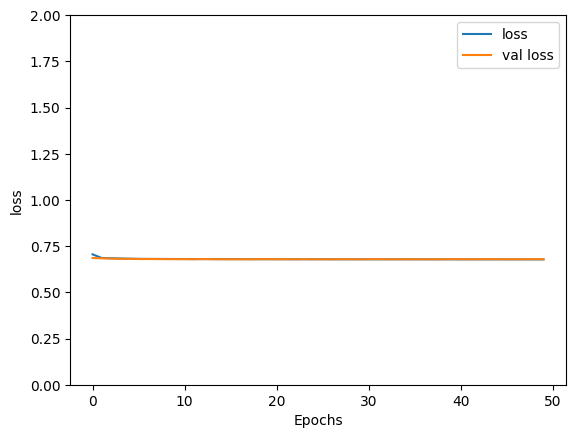

In [34]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.ylim(0., 2.)
plt.show()

In [35]:
np.sum(Y_train[:,0] == 1)

449756

In [36]:
ws = dctr.predict(X_train, batch_size=1000)

900/900 [==============================] - 5s 6ms/step


In [37]:
ws

array([[0.4450034 , 0.55499667],
       [0.55097127, 0.44902867],
       [0.4409839 , 0.5590161 ],
       ...,
       [0.81244236, 0.18755767],
       [0.43737617, 0.56262386],
       [0.47472045, 0.5252795 ]], dtype=float32)

In [38]:
#Get the entries where it's nominal (index 0 is high) or varied (index 1 is high)
def_indices = np.where(Y_train[:,0] == 1)
var_indices = np.where(Y_train[:,1] == 1)

In [39]:
weights_0 = ws[:,0]/ws[:,1] #weights varied->nominal are the likelihood ratio 

(array([0.00000e+00, 3.00000e+00, 8.00000e+00, 3.30000e+01, 9.70000e+01,
        4.19000e+02, 1.97510e+04, 1.12539e+05, 1.47996e+05, 6.24670e+04,
        2.63320e+04, 1.72110e+04, 1.24400e+04, 9.28700e+03, 7.12900e+03,
        5.42800e+03, 4.42800e+03, 3.57000e+03, 2.96500e+03, 2.35000e+03,
        1.91900e+03, 1.66300e+03, 1.45600e+03, 1.20800e+03, 1.06200e+03,
        9.48000e+02, 8.02000e+02, 6.92000e+02, 6.20000e+02, 4.77000e+02,
        4.57000e+02, 4.09000e+02, 3.77000e+02, 3.19000e+02, 3.16000e+02,
        2.87000e+02, 2.73000e+02, 2.10000e+02, 2.27000e+02, 1.77000e+02,
        1.63000e+02, 1.33000e+02, 1.26000e+02, 1.11000e+02, 1.15000e+02,
        1.06000e+02, 1.01000e+02, 9.10000e+01, 7.10000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]

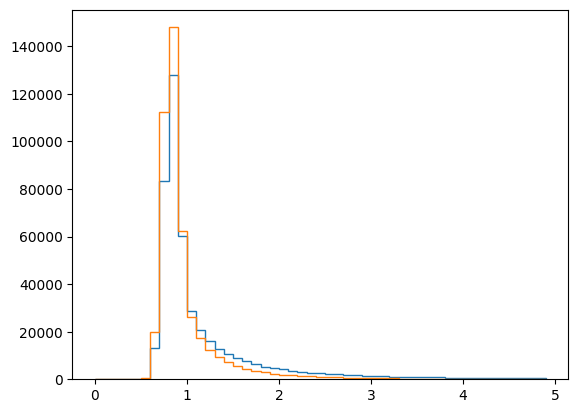

In [40]:
plt.hist(weights_0[def_indices], np.arange(0.,5, .1), histtype='step')
plt.hist(weights_0[var_indices], np.arange(0.,5, .1), histtype='step')

In [41]:
ws_val = dctr.predict(X_val, batch_size=1000)
indices_val = np.where(Y_val[:,0]==1)
indices2_val = np.where(Y_val[:,1]==1)

100/100 [==============================] - 1s 6ms/step


In [42]:
weights_0_val = ws_val[:,0]/ws_val[:,1]

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        4.4000e+01, 2.0510e+03, 1.2205e+04, 1.6569e+04, 6.8820e+03,
        2.9500e+03, 1.9110e+03, 1.3900e+03, 1.0670e+03, 7.8600e+02,
        5.9600e+02, 4.7900e+02, 3.6600e+02, 3.2700e+02, 2.7500e+02,
        2.2300e+02, 1.9600e+02, 1.6100e+02, 1.4200e+02, 1.2500e+02,
        1.0800e+02, 8.8000e+01, 7.5000e+01, 7.5000e+01, 4.6000e+01,
        4.9000e+01, 5.5000e+01, 5.1000e+01, 3.6000e+01, 3.6000e+01,
        3.8000e+01, 3.0000e+01, 2.1000e+01, 3.3000e+01, 2.1000e+01,
        1.4000e+01, 1.7000e+01, 2.0000e+01, 1.5000e+01, 1.0000e+01,
        1.6000e+01, 1.1000e+01, 9.0000e+00, 1.0000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
 [<matplotlib.patches.Polygon at 0x757aab4d053

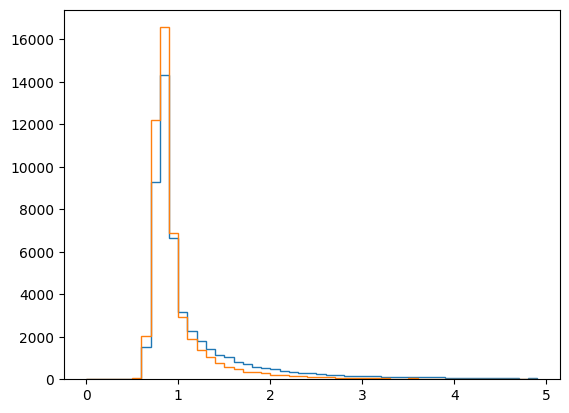

In [43]:
plt.hist(weights_0_val[indices_val], np.arange(0.,5, .1), histtype='step')
plt.hist(weights_0_val[indices2_val], np.arange(0.,5, .1), histtype='step')

In [44]:
testpdg = .6

In [45]:


print(X_train[def_indices, :, 3])
print(((X_train[def_indices, :, 3] > testpdg-.05) & (X_train[def_indices, :, 3] < testpdg +.05)).shape)


[[[0.8 0.8 0.6 ... 0.  0.  0. ]
  [0.8 0.6 0.8 ... 0.  0.  0. ]
  [0.8 0.6 0.6 ... 0.  0.  0. ]
  ...
  [0.8 0.8 0.6 ... 0.  0.  0. ]
  [0.6 0.8 0.6 ... 0.  0.  0. ]
  [0.6 0.8 0.  ... 0.  0.  0. ]]]
(1, 449756, 20)


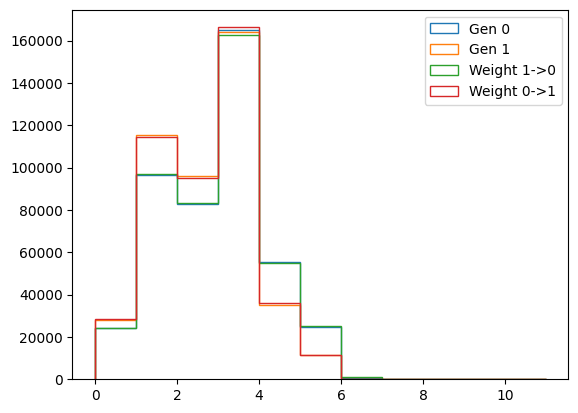

In [46]:
default_multiplicity = np.sum(((X_train[def_indices, :, 3] > testpdg-.05) & (X_train[def_indices, :, 3] < testpdg +.05))[0], axis=1)
varied_multiplicity = np.sum(((X_train[var_indices, :, 3] > testpdg-.05) & (X_train[var_indices, :, 3] < testpdg +.05))[0], axis=1)
plt.hist(default_multiplicity, np.arange(0, 12, ), histtype='step', label='Gen 0')
plt.hist(varied_multiplicity, np.arange(0, 12, ), histtype='step', label='Gen 1')
plt.hist(varied_multiplicity, np.arange(0, 12, ), histtype='step', label='Weight 1->0', weights=weights_0[var_indices])
plt.hist(default_multiplicity, np.arange(0, 12, ), histtype='step', label='Weight 0->1', weights=1./weights_0[def_indices])
plt.legend()

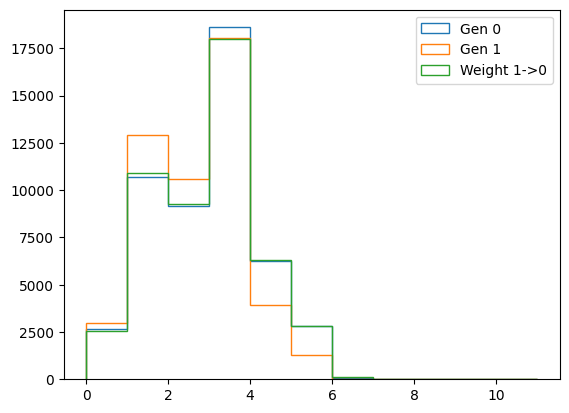

In [47]:
def_indices_val = np.where(Y_val[:,0] == 1)
var_indices_val = np.where(Y_val[:,1] == 1)
plt.hist(np.sum(((X_val[def_indices_val, :, 3] > testpdg-.05) & (X_val[def_indices_val, :, 3] < testpdg +.05))[0], axis=1), np.arange(0, 12, ), histtype='step', label='Gen 0')
plt.hist(np.sum(((X_val[var_indices_val, :, 3] > testpdg-.05) & (X_val[var_indices_val, :, 3] < testpdg +.05))[0], axis=1), np.arange(0, 12, ), histtype='step', label='Gen 1')
plt.hist(np.sum(((X_val[var_indices_val, :, 3] > testpdg-.05) & (X_val[var_indices_val, :, 3] < testpdg +.05))[0], axis=1), np.arange(0, 12, ), histtype='step', label='Weight 1->0', weights=weights_0_val[var_indices_val])
# plt.hist(np.sum(((X_train[def_indices, :, 3] > testpdg-.5) & (X_train[def_indices, :, 3] < testpdg +.5))[0], axis=1), np.arange(0, 12, ), histtype='step', label='Weight 0->1', weights=1./weights_0[def_indices])
plt.legend()

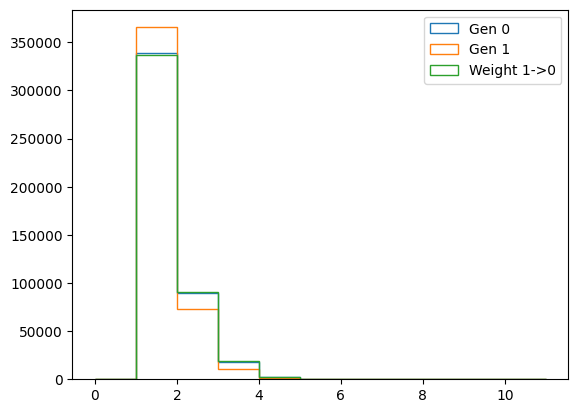

In [48]:
plt.hist(np.sum((X_train[def_indices, :, 3] < 0)[0], axis=1), np.arange(0, 12, ), histtype='step', label='Gen 0')
plt.hist(np.sum((X_train[var_indices, :, 3] < 0)[0], axis=1), np.arange(0, 12, ), histtype='step', label='Gen 1')
plt.hist(np.sum((X_train[var_indices, :, 3] < 0)[0], axis=1), np.arange(0, 12, ), histtype='step', label='Weight 1->0', weights=weights_0[var_indices])
plt.legend()